In [275]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Imports

In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

In [277]:
# random seed for Torch and NumPy

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

# Data

## Loading our Data

Let's load in our data from the csv files into a pandas dataframe.

In [278]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [279]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I'm splitting the data manually here with a `80:20` ratio. 

In [280]:
feature_train_tensor = torch.tensor(df_train.drop('label', axis=1)[0:33600].to_numpy())
label_train_tensor = torch.tensor(df_train.loc[:33599, 'label'].to_numpy())

feature_val_tensor = torch.tensor(df_train.drop('label', axis=1)[33600:].to_numpy())
label_val_tensor = torch.tensor(df_train.loc[33600:, 'label'].to_numpy())

test_tensor = torch.tensor(df_test.to_numpy())

A simple normalization to ensure the values are between `0` and `1`

In [281]:
feature_train_tensor = feature_train_tensor.float() / 255.0
feature_val_tensor = feature_val_tensor.float() / 255.0
test_tensor = test_tensor.float() / 255.0

In [282]:
feature_train_tensor.shape, label_train_tensor.shape

(torch.Size([33600, 784]), torch.Size([33600]))

## Creating a Custom Dataset Class

A simple custom dataset class in reference to [this PyTorch Documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

In [283]:
class MyDataset(Dataset):
    def __init__(self, data, target=None, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform:
            x = self.transform(x)

        if self.target is not None:
            y = self.target[idx]
            if self.target_transform:
                y = self.target_transform(y) 
            return x, y
        else:
            return x
        

Creating our `DataLoader` [objects](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) here. 

In [284]:
train_dataset = MyDataset(data=feature_train_tensor, target=label_train_tensor)
val_dataset = MyDataset(data=feature_val_tensor, target=label_val_tensor)
test_dataset = MyDataset(data=test_tensor)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, collate_fn=None)

In [285]:
feature = next(iter(train_loader))[0]
feature.shape

torch.Size([128, 784])

## Having a look at our dataset

Let's have a look at some of our training dataset alongside their labels, we can use matplotlib to do some simple plotting. It's always good to see what we're working with.

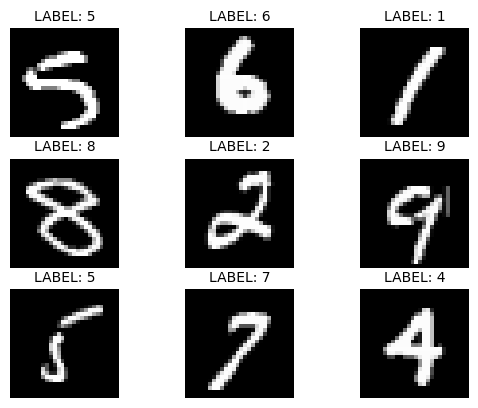

In [286]:
for i in range(1, 10):
    plt.subplot(3, 3, i)
    sample = torch.randint(len(train_dataset), size=(1,)).item()
    feature, label = train_dataset[sample]
    plt.imshow(feature.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"LABEL: {label.item()}", fontsize=10)

# The Action

## Writing our Training Loop

We'll write a function that trains one epoch and returns a list of training losses

In [287]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    model.train()

    losses = []

    for idx, data in enumerate(train_loader):
        
        features, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())       
        # print(f"Batch ID: {idx} \t Loss: {loss.item()}")
    return losses

## Writing our evaluation function

In [288]:
def evaluate(dataloader, model, criterion, device):
    model.eval() # weights are not updated

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0
        
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            loss = criterion(outputs, labels) # we need val loss
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_correct += (preds==labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples * 100

    return avg_loss, accuracy
    

In [289]:
def train_modelcv(train_loader, test_loader, model, criterion, optimizer, num_epochs, device, scheduler):
    train_losses = []
    val_losses = []
    best_measure = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)
        
        train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, measure = evaluate(test_loader, model, criterion, device)
        val_losses.append(val_loss)

        scheduler.step(measure)

        print("Performance measure: ", measure)
        print("Current Learning Rate: ", optimizer.param_groups[0]['lr'])

        if measure > best_measure:
            best_weights = model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print(f"Current Best is epoch {best_epoch} with {best_measure} %")

    return best_weights, best_measure, best_epoch, train_losses, val_losses

        
        

## Building our model

Here comes the fun part, actually building our Model! I'm going to build a model very similar to the LeNet architecture, which is a really simple and humble architecture. The original implementation uses `tanh` as the activation, but I've changed it to `ReLU` here. 

In [290]:
class LeNetModel(nn.Module):

    def __init__(self, indims, numcl):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        self.pool = nn.AvgPool2d(kernel_size=2)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, numcl)

    def forward(self, x):
        x = x.reshape(x.size(0), -1, 28, 28)
        v = self.pool(F.relu(self.conv1(x)))
        v = self.pool(F.relu(self.conv2(v)))

        v = v.view(-1, 16*4*4)
        v = F.relu(self.fc1(v))
        v = F.relu(self.fc2(v))
        v = self.fc3(v)

        return v
        
        

# Hyperparameters

In [291]:
num_epochs = 100
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = torch.nn.CrossEntropyLoss()

model = LeNetModel(784, 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# a scheduler to decrease learning rate if accuracy does not change after <patience> epochs
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=20)

# Main Loop

Where the action is...

In [292]:
best_weights, best_measure, best_epoch, train_losses, val_losses = train_modelcv(train_loader,
                                                                                 val_loader,
                                                                                 model, 
                                                                                 loss, 
                                                                                 optimizer,
                                                                                 num_epochs,
                                                                                 device,
                                                                                 scheduler)

                                                                                 

Epoch 0/99
----------
Performance measure:  92.66666666666666
Current Learning Rate:  0.001
Current Best is epoch 0 with 92.66666666666666 %
Epoch 1/99
----------
Performance measure:  96.17857142857143
Current Learning Rate:  0.001
Current Best is epoch 1 with 96.17857142857143 %
Epoch 2/99
----------
Performance measure:  96.61904761904762
Current Learning Rate:  0.001
Current Best is epoch 2 with 96.61904761904762 %
Epoch 3/99
----------
Performance measure:  97.05952380952381
Current Learning Rate:  0.001
Current Best is epoch 3 with 97.05952380952381 %
Epoch 4/99
----------
Performance measure:  97.69047619047619
Current Learning Rate:  0.001
Current Best is epoch 4 with 97.69047619047619 %
Epoch 5/99
----------
Performance measure:  97.75
Current Learning Rate:  0.001
Current Best is epoch 5 with 97.75 %
Epoch 6/99
----------
Performance measure:  97.92857142857143
Current Learning Rate:  0.001
Current Best is epoch 6 with 97.92857142857143 %
Epoch 7/99
----------
Performance mea

In [293]:
print(f"Best Measure: {best_measure} \t Best Epoch: {best_epoch}")

Best Measure: 99.07142857142858 	 Best Epoch: 78


# Plot train-val loss

In [294]:
def plot_train_val_loss(train_loss, val_loss):
    # get average loss for training and validation
    t_losses = [np.mean(i) for i in train_loss]
    v_losses = [np.mean(i) for i in val_loss]
    plt.plot(t_losses, label='train loss')
    plt.plot(v_losses, label='val loss')
    plt.legend()
    plt.show()

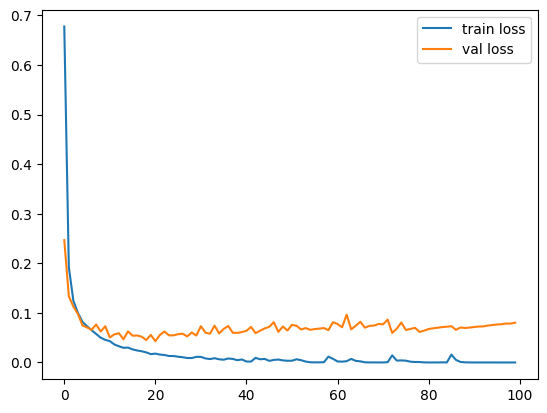

In [295]:
plot_train_val_loss(train_losses, val_losses)

In [296]:
# load model with best weights
model.load_state_dict(best_weights)
model.eval()
predictions = []
with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = model(features)

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

image_id = [i for i in range(1, len(predictions)+1)]
submission_df = pd.DataFrame({
    "ImageId": image_id,
    "Label": predictions
})

submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [297]:
submission_df.to_csv("/kaggle/working/submission_LeNet_Relu.csv", index=False)